## Q Learning and SARSA algorithm


The aim of this assignment is to use Q Learning to teach an agent how to traverse a frozen lake, missing the holes and arriving at the goal destination.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties

Setup the constants

In [2]:
# percentage to exploration
EPSILON = 0.1

# learing rate
ALPHA = 0.5

# discount reward for Q-Learning and Expected Sarsa
GAMMA = 0.9

episodes = 10000

# assign values to actions
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3


# values used in the creation of the lake
BOARD_ROWS = 5
BOARD_COLS = 5
START = [0, 0]
GOAL = [4, 4]
HOLE = [[1, 0], [1, 3], [3, 1], [4, 2]]
GOAL_REWARD = 10
PENALTY = -5

Helper function to draw the lake

In [3]:
def draw_empty_lake(q_table, title):

    figure(figsize=(8, 6), dpi=80)
    optimal_policy = []
    for i in range(0, BOARD_ROWS):
        optimal_policy.append([])
        for j in range(0, BOARD_COLS):
            if [i, j] == GOAL:
                optimal_policy[-1].append('Goal({}, {})'.format(i, j))
                continue
            if [i, j] in HOLE:
                optimal_policy[-1].append('Hole({}, {})'.format(i, j))
                continue
            if [i, j] == START:
                optimal_policy[-1].append('Start({}, {})'.format(i, j))
                continue
            else:
                optimal_policy[-1].append('({}, {})'.format(i, j))
    tbl = plt.table(cellText=optimal_policy, bbox=[0, 0, 1, 1], cellLoc='center')
    tbl[tuple(START)].set_facecolor('green')
    for h in HOLE:
        tbl[tuple(h)].set_facecolor('red')
    tbl[tuple(GOAL)].set_facecolor('yellow')
    plt.title(title)

    plt.axis('off')
    plt.show()

Draw a map of the forzen lake

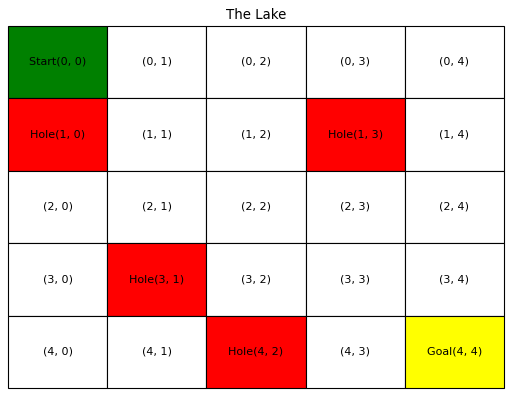

In [4]:
start_lake= np.zeros((BOARD_ROWS, BOARD_COLS, 4))
draw_empty_lake(start_lake, 'The Lake')

Helper function to draw the policy once it has been found

In [5]:
def draw_policy(q_table, title, r, c):

    figure(figsize=(r, c), dpi=80)
    optimal_policy = []
    for i in range(0, BOARD_ROWS):
        optimal_policy.append([])
        for j in range(0, BOARD_COLS):
            if [i, j] == GOAL:
                optimal_policy[-1].append('Goal({}, {})'.format(i, j))
                continue
            if [i, j] in HOLE:
                optimal_policy[-1].append('Hole({}, {})'.format(i, j))
                continue
            if [i, j] == START:
                optimal_policy[-1].append('Start({}, {})'.format(i, j))
                continue
            bestAction = np.argmax(q_table[i, j, :])
            if bestAction == UP:
                optimal_policy[-1].append(r"$\uparrow}$")
            elif bestAction == DOWN:
                optimal_policy[-1].append(r"$\downarrow$")
            elif bestAction == LEFT:
                optimal_policy[-1].append(r"$\leftarrow}$")
            elif bestAction == RIGHT:
                optimal_policy[-1].append(r"$\rightarrow}$")
            else:
                optimal_policy[-1].append('')

    tbl = plt.table(cellText=optimal_policy, bbox=[0, 0, 1, 1], cellLoc='center')

    tbl[tuple(START)].set_facecolor('green')
    for h in HOLE:
        tbl[tuple(h)].set_facecolor('red')
    tbl[tuple(GOAL)].set_facecolor('yellow')
    plt.title(title)

    plt.axis('off')
    plt.show()

Helper function to draw the learned values once they have been found

In [6]:
def draw_grid_values(q_table, title, r, c):
    figure(figsize=(r, c), dpi=80)
    tbl = np.round(np.amax(q_table, axis=2), 3)

    tbl = plt.table(cellText=tbl, bbox=[0, 0, 1, 1], cellLoc='center')
    tbl[tuple(START)].set_facecolor('green')
    for h in HOLE:
        tbl[tuple(h)].set_facecolor('red')
    tbl[tuple(GOAL)].set_facecolor('yellow')
    plt.title(title)

    plt.axis('off')
    plt.show()

State Class:

This is a modified version of the Value Iteration class presented in week 8.  It contains the operations on state and action values as described in the Q-Learning algorithm.

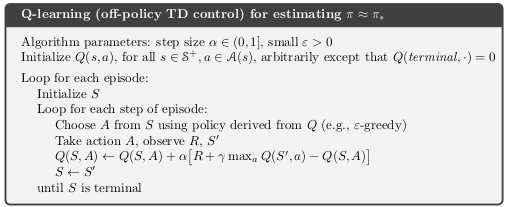

Image taken from Chapter 6, Reinforcement Learning: An Introduction, second edition.  By Richard S. Sutton and Andrew G. Barton

In [7]:
class State:

    # get the reward from being in a particulate staet
    def get_reward(self, state):
        if state == GOAL:
            return GOAL_REWARD
        if state in HOLE:
            return PENALTY
        # in this game there is a penalty for making a move
        else:
            return -1

    def next_position(self, state, action):

        row_index, col_index = state
        next_state = state
        # get the next position, make sure the agent
        # stays on the lake.  If it attempts to go out of
        # bounds, remain in place.
        if action == UP and row_index > 0:
            next_state = [row_index - 1, col_index]
        elif action == LEFT and col_index > 0:
            next_state = [row_index, col_index - 1]
        elif action == RIGHT and col_index < BOARD_COLS - 1:
            next_state = [row_index, col_index + 1]
        elif action == DOWN and row_index < BOARD_ROWS - 1:
            next_state = [row_index + 1, col_index]

        reward = round(self.get_reward(next_state), 3)

        return next_state, reward

    # choose an action based on epsilon greedy algorithm
    def choose_action(self, state, q_value):
        x, y = state
        # select the action with the highest value if the
        # random number, selected between 0 and 1 is lower than
        # the epsilon value
        if np.random.random() > EPSILON:
            # if more than one action has a similar value, select one at random
            # https://stackoverflow.com/questions/42071597/numpy-argmax-random-tie-breaking/42071648
            return np.random.choice(np.flatnonzero(q_value[x, y] == q_value[x, y].max()))
        else:
            # choose a random action from the 4 possible directions
            return np.random.randint(4)

In [8]:
class QLearningAgent:

    def __init__(self):
        self.State = State()


    @staticmethod
    def is_episode_over(state):
        is_over = False
        if state == GOAL:
            is_over = True
        for i in HOLE:
            if state == i:
                is_over = True
        return is_over

    def q_learning(self, q_table, alpha=ALPHA, gamma=GAMMA):
        state = START
        rewards = 0.0
        while not self.is_episode_over(state):
            # choose A from S using Policy derived from Q (epsilon-greedy)
            action = self.State.choose_action(state, q_table)
            # Take action A, observe R, S'
            next_state, reward = self.State.next_position(state, action)
            rewards += reward
            # Q-Learning update
            current_x, current_y = state
            next_x, next_y = next_state
            # Q(S, A) <- Q(S, A) + alpha *[R + gamma * max Q*(s′,a′) - Q(S, A)]
            q_table[current_x, current_y, action] += alpha * (
                    reward + gamma * np.max(q_table[next_x, next_y, :]) -
                    q_table[current_x, current_y, action])
            # S <- S'
            state = next_state
        return rewards

For comparison, I also implemented the SARSA algorithm.  

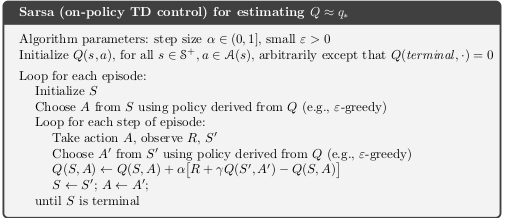

Image taken from Chapter 6, Reinforcement Learning: An Introduction, second edition.  By Richard S. Sutton and Andrew G. Barton

In [9]:
class SARSAAgent:

    def __init__(self):
        self.State = State()

    @staticmethod
    def is_episode_over(state):
        is_over = False
        if state == GOAL:
            is_over = True
        for i in HOLE:
            if state == i:
                is_over = True
        return is_over


    def sarsa(self, q_table, alpha=ALPHA):
        # Initialize Q(s, a), for all s element S, element 2 A(s),
        # q_table initialized prior to calling this function
        # as is looping over each episode
        # Initialize S
        state = START
        # Choose A from S using policy derived from Q (e.g., epsilon-greedy)
        action = self.State.choose_action(state, q_table)
        rewards = 0.0
        # Loop for each step of episode:
        while not self.is_episode_over(state):
            # Take action A, observe R, S'
            next_state, reward = self.State.next_position(state, action)
            # Choose A 0 from S 0 using policy derived from Q (e.g., eplison-greedy)
            next_action = self.State.choose_action(next_state, q_table)
            # Q(S, A) <- Q(S, A) + alpha[ R + gamma * Q(S'' , A' ) - Q(S, A)
            # this is the difference beteen SARSA and Q-Learning, not looking of
            # maximum discounted future reward
            next_x, next_y = next_state
            current_x, current_y = state
            q_table[current_x, current_y, action] += alpha * (
                    reward + GAMMA * q_table[next_x, next_y, next_action] -
                    q_table[current_x, current_y, action])
            # S <- S'; A <- A'
            state = next_state
            action = next_action
            # used in plotting the diagram
            rewards += reward
        return rewards

Once the classes have been created, we can run the frozen lake experiment for 10000 episodes and output the action value estimates at the end of the learning process.  I have also output the policy.

Q-Learning Optimal Policy:


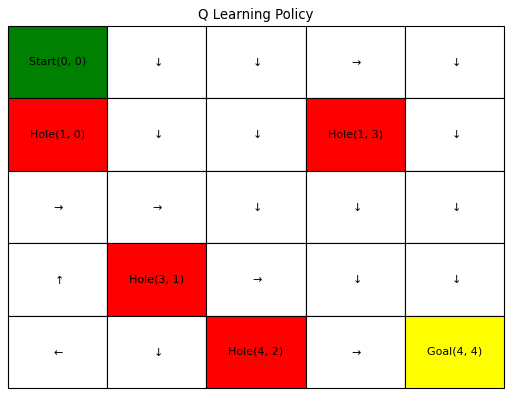

Q Learning Values


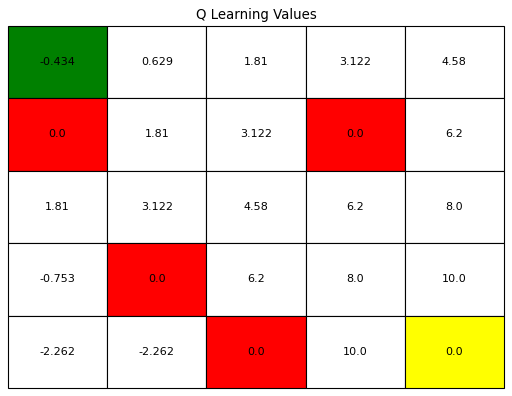

In [10]:
ql_agent = QLearningAgent()
rewards_q_learning = np.zeros(episodes)
# create the Q Table. This holds the [state, action] values
# so for every position on the grid, it will hold a value for
# each of the 4 possible actions
q_table = np.zeros((BOARD_ROWS, BOARD_COLS, 4))
for i in range(0, episodes):
    rewards_q_learning[i] += ql_agent.q_learning(q_table)
    
# display optimal policy
print('Q-Learning Optimal Policy:')
draw_policy(q_table, 'Q Learning Policy', 8, 6)
print('Q Learning Values')
draw_grid_values(q_table, 'Q Learning Values', 8, 6)



I also run the frozen lake experiment for 10000 episodes with the SARA agent and output the action value estimates and the policy at the end of the learning process.

Sarsa Optimal Policy:


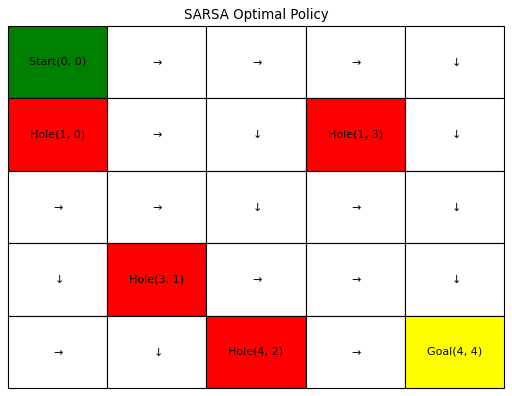

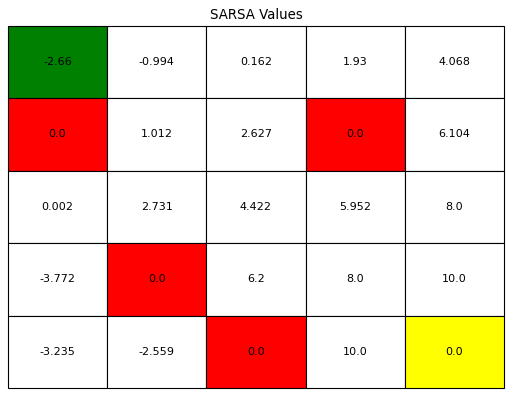

In [11]:
sarsa_agent = SARSAAgent()
rewards_sarsa = np.zeros(episodes)
sarsa_table = np.zeros((BOARD_ROWS, BOARD_COLS, 4))
for i in range(0, episodes):
    rewards_sarsa[i] += sarsa_agent.sarsa(sarsa_table)

# display optimal Q-Learning policy
print('Sarsa Optimal Policy:')
draw_policy(sarsa_table, 'SARSA Optimal Policy', 8 ,6)
draw_grid_values(sarsa_table, 'SARSA Values', 8, 6)

We can see from the plots above that the two algorithms produce different policies

Now we can plot a curve of the reward per episode.  Over the 10000 there is alot of overlap, however the q-learning performance is slightly worse than that of SARSA, because of e-greedy action selection.

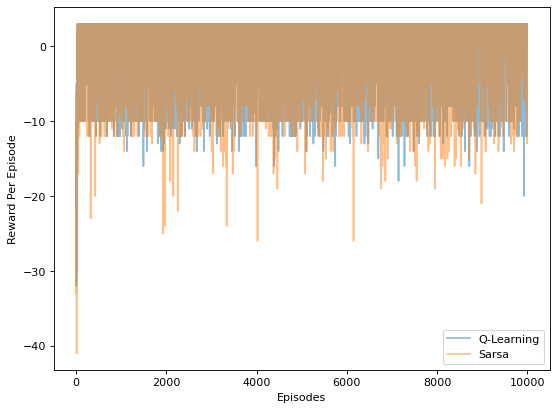

In [12]:
figure(figsize=(8, 6), dpi=80)
plt.plot(rewards_q_learning, label='Q-Learning', alpha=0.5)
plt.plot(rewards_sarsa, label='Sarsa', alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Reward Per Episode')
plt.legend()

plt.show()

For comparison purposes I also show the first one hundred episodes:

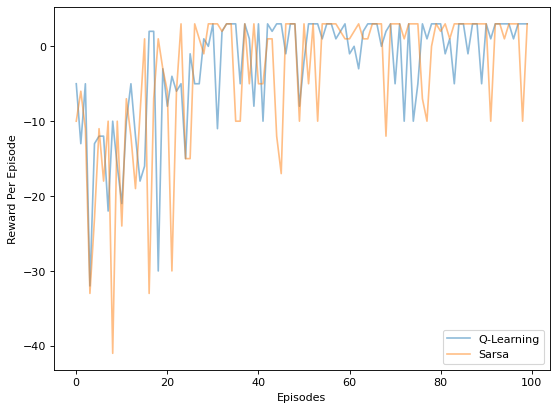

In [13]:
figure(figsize=(8, 6), dpi=80)
plt.plot(rewards_q_learning[:100], label='Q-Learning', alpha=0.5)
plt.plot(rewards_sarsa[:100], label='Sarsa', alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Reward Per Episode')
plt.legend()

plt.show()

Just to prove the two algorithms are working as expected, change the world to the cliff walking excercise

In [14]:
# values used in the creation of the lake
BOARD_ROWS = 4
BOARD_COLS = 12
START = [3, 0]
GOAL = [3, 11]
HOLE = [[3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10]]
GOAL_REWARD = 0
PENALTY = -100

Q-Learning Optimal Policy:


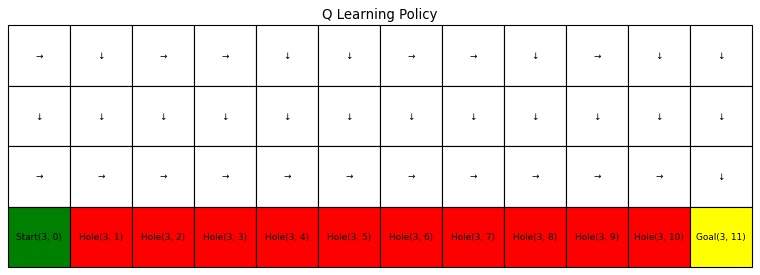

Q Learning Values


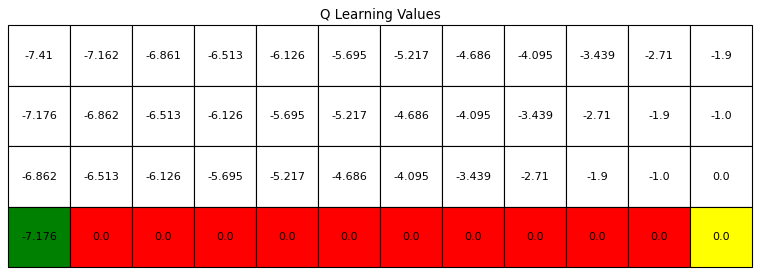

In [15]:
ql_agent = QLearningAgent()
rewards_q_learning = np.zeros(episodes)
# create the Q Table. This holds the [state, action] values
# so for every position on the grid, it will hold a value for
# each of the 4 possible actions
q_table = np.zeros((BOARD_ROWS, BOARD_COLS, 4))
for i in range(0, episodes):
    rewards_q_learning[i] += ql_agent.q_learning(q_table)
    
# display optimal policy
print('Q-Learning Optimal Policy:')
draw_policy(q_table, 'Q Learning Policy', 12, 4)
print('Q Learning Values')
draw_grid_values(q_table, 'Q Learning Values', 12, 4)


Sarsa Optimal Policy:


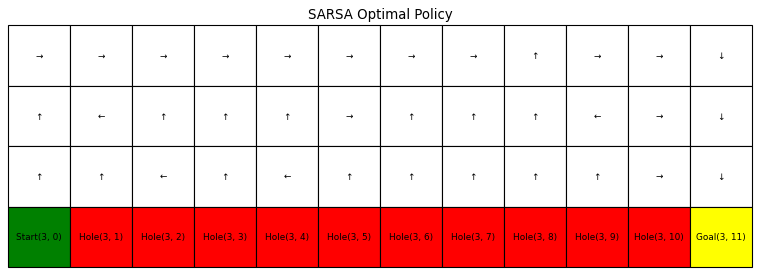

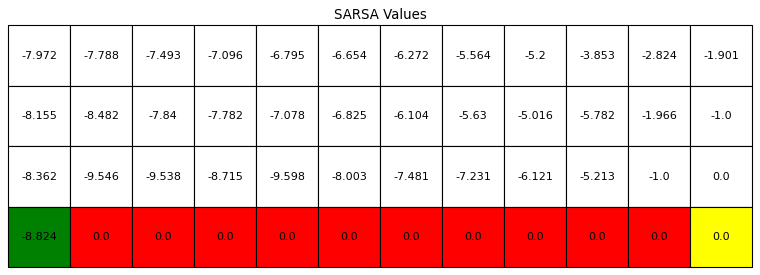

In [16]:
sarsa_agent = SARSAAgent()
rewards_sarsa = np.zeros(episodes)
sarsa_table = np.zeros((BOARD_ROWS, BOARD_COLS, 4))
for i in range(0, episodes):
    rewards_sarsa[i] += sarsa_agent.sarsa(sarsa_table)

# display optimal Q-Learning policy
print('Sarsa Optimal Policy:')
draw_policy(sarsa_table, 'SARSA Optimal Policy', 12 ,4)
draw_grid_values(sarsa_table, 'SARSA Values', 12, 4)